# Template Matching for A. varius Call Detection

## Package import and Directory/Parameters Setup

In [1]:
from opensoundscape import Audio, Spectrogram
import pandas as pd
from glob import glob
from scipy import signal
import os
import noisereduce as nr
import numpy as np
import IPython.display as ipd

In [2]:
# Folder with sample audio files as test data
SAMPLE_AUDIO_DIR = 'sample_audio'
# Folder with template files, containing 6 audio clips (each 3 seconds long)
TEMPLATE_DIR = 'sample_templates'
# Folder where the results are saved, as a CSV for each template
OUTPUT_DIR = 'sample_scores/template_matching'

# Noise reduction proportion and required audio sample rate
p = 0.98
SAMPLE_RATE = 22050

## Define main and helper functions

In [3]:
def load_template(template_file, prop_nr=0, sample_rate=SAMPLE_RATE):
    """
    Load a template audio file and apply noise reduction if desired.
    
    Parameters:
        template_file (str): Path to the template .wav file.
        prop_nr (float): Proportion for noise reduction; by default, no noise reduction.
        sample_rate (int): Sampling rate for loading audio.
        
    Returns:
        numpy.ndarray: The template audio samples.
    """
    audio = Audio.from_file(template_file, sample_rate=sample_rate)
    if prop_nr > 0:
        audio.samples = nr.reduce_noise(
            y=audio.samples, 
            sr=audio.sample_rate, 
            prop_decrease=prop_nr
        )
    return audio.samples

In [4]:
def template_matching(template_file, prop_nr, test_audio_file, base_csv_path, sample_rate=SAMPLE_RATE):
    """
    For a given template and one test audio file:
      - Load and noise-reduce both signals.
      - Compute the cross-correlation.
      - Select the top 500 correlation results.
      - Save the results to a CSV file.
    
    Parameters:
        template_file (str): Path to the template .wav file.
        prop_nr (float): Noise reduction proportion.
        test_audio_file (str): Path to the test audio .wav file.
        base_csv_path (str): Directory where result CSVs will be stored.
        sample_rate (int): Audio sample rate.
        
    Returns:
        df (pd.DataFrame): DF containing results for one template and one test file.
    """
    # Load and process test audio
    audio = Audio.from_file(test_audio_file, sample_rate=sample_rate)
    samples = nr.reduce_noise(
        y=audio.samples,
        sr=audio.sample_rate,
        prop_decrease=prop_nr,
        n_jobs=1
    )
    
    # Load and process the template audio
    template_samples = load_template(template_file, prop_nr, sample_rate)
    
    # Compute cross-correlation
    corr = signal.correlate(samples, template_samples, mode='full')
    lags = signal.correlation_lags(len(template_samples), len(samples))
    
    # Generate a template name based on the file name (without extension)
    temp_name = os.path.splitext(os.path.basename(template_file))[0]
    
    # Build a DataFrame with correlation data and select top 500 matches
    df = pd.DataFrame({'correlation': corr, 'lag': lags})
    df = df.sort_values(by='correlation', ascending=False).head(500)
    
    N = len(samples) # total samples in test audio
    M = len(template_samples) # samples in template
    
    df['Template_Name'] = temp_name
    df['file'] = test_audio_file
    
    df['start_time'] = (df['lag'] + (N - 1)) / sample_rate
    df = df[(df['start_time'] >= 0) & (df['start_time'] <= (N - M) / sample_rate)]
    
    # Save results to CSV
    os.makedirs(base_csv_path, exist_ok=True)
    csv_file_path = os.path.join(base_csv_path, f"{temp_name}_results.csv")
    df.to_csv(csv_file_path, mode='a', header=not os.path.isfile(csv_file_path), index=False)
    
    return df

In [5]:
def run_process_on_template(template_file, prop_nr, test_files):
    """
    Run template matching on all test audio files using a single template.
    
    Parameters:
        template_file (str): Path to a template file.
        prop_nr (float): Noise reduction proportion.
        test_files (list): List of paths to test audio files.
    Returns:
        pd.DataFrame: Cross-correlation results for one template on all test files.
    """
    all_dfs = []
    for test_audio_file in test_files:
        file_df = template_matching(template_file, prop_nr, test_audio_file, OUTPUT_DIR)
        all_dfs.append(file_df)
    return pd.concat(all_dfs)

## Get list of template audio files and test audio files

In [6]:
template_files = glob(os.path.join(TEMPLATE_DIR, '*.wav'))
test_audio_files = glob(os.path.join(SAMPLE_AUDIO_DIR, '*.wav'))

## Process each template on each test audio file

In [7]:
all_temps = []
for template_file in template_files:
    temp_df = run_process_on_template(template_file, p, test_audio_files)
    all_temps.append(temp_df)

## Review top-scoring clips

In [8]:
full_output = pd.concat(all_temps).sort_values(by='correlation',ascending=False)
full_output['start_time'] = full_output['start_time'].astype(int)
full_output = full_output.drop_duplicates(['start_time','file'])

In [9]:
display_clip_duration = 3

def display_results(result_tuple, play_audio=True):
    """
    - Calculate and plot the spectrogram of the audio clip selected for review.
    - Report relevant information about the clip, including its RIBBIT score.
    - If desired, listen to the audio clip.
    """
    print(f"Displaying audio file: {result_tuple[0]} at {result_tuple[1]} seconds:")
    # Load in desired audio clip
    audio = Audio.from_file(result_tuple[0], 
                            offset=result_tuple[1], 
                            duration=display_clip_duration)
    # Display spectrogram from our audio clip
    Spectrogram.from_audio(
        audio,
        window_samples=256,
        overlap_fraction=.9
    ).bandpass(0,5000).plot()
    # Play audio! :)
    if play_audio:
        ipd.display(ipd.Audio(audio.samples,rate=audio.sample_rate,autoplay=False))
    print(f"This clip got a score of {result_tuple[2]}.\n\n")

Displaying audio file: sample_audio/test_dset_3.wav at 1 seconds:


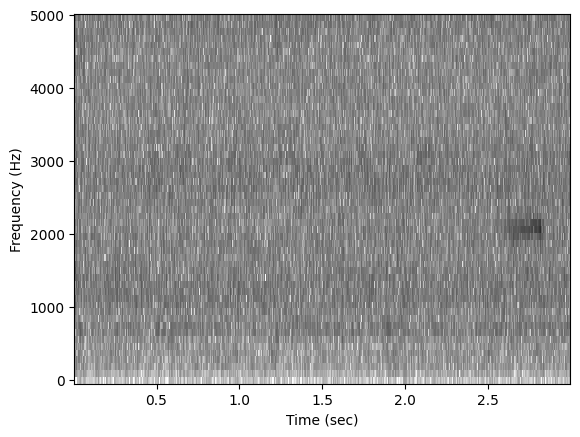

This clip got a score of 0.29865559935569763.


Displaying audio file: sample_audio/test_dset_3.wav at 2 seconds:


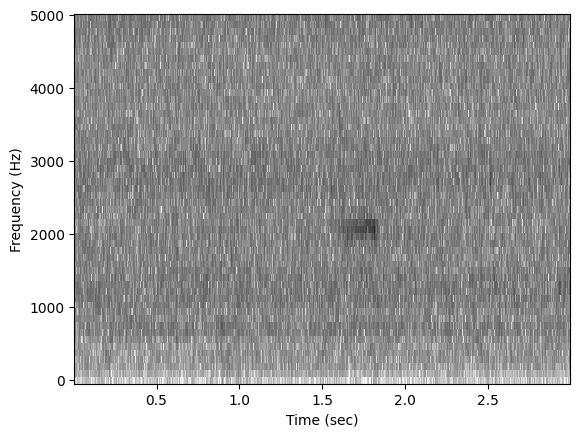

This clip got a score of 0.2704617977142334.


Displaying audio file: sample_audio/test_dset_2.wav at 27 seconds:


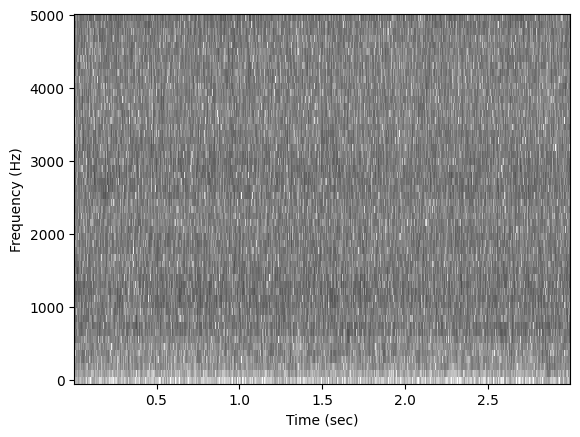

This clip got a score of 0.22657491266727448.


Displaying audio file: sample_audio/test_dset_3.wav at 5 seconds:


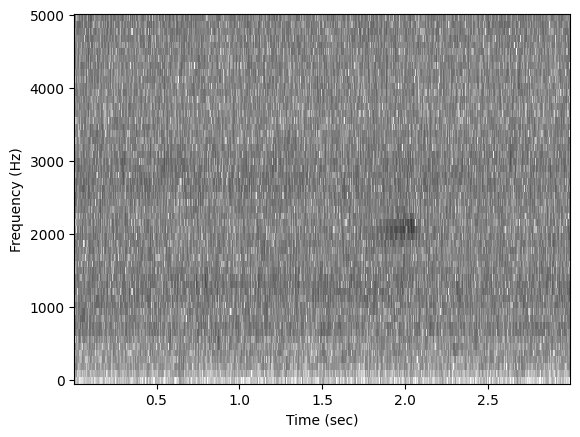

This clip got a score of 0.213246151804924.


Displaying audio file: sample_audio/test_dset_1.wav at 29 seconds:


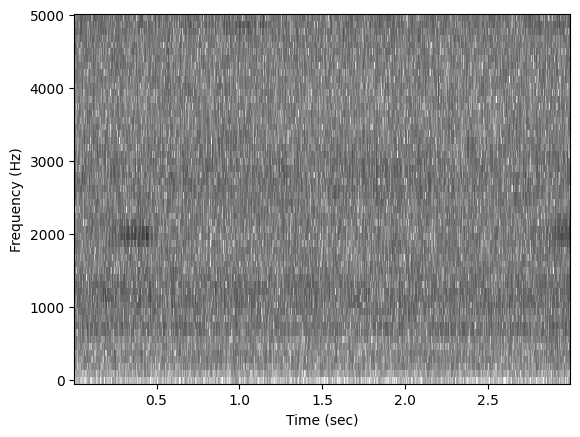

This clip got a score of 0.21111097931861877.




In [10]:
"""
Take a closer look at our last score DataFrame to display a desired 
number of highest-scoring clips from the latest file analyzed.
"""
# Set desired number of review clips.
n_review_clips = 5
# Subset DataFrame to that number of high-scoring clips.
clips_to_review = full_output.head(n_review_clips)
# Check out your results!
for index, row in clips_to_review.reset_index().iterrows():
    display_results(tuple(row[["file","start_time","correlation"]]), play_audio=True)